[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/faiss-tutorial/intro_speed_tests.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/faiss-tutorial/intro_speed_tests.ipynb)

# FAISS Speed Tests

This notebook accompanies the FAISS intro.ipynb file, here we setup a testing function to test the query time of three different index structures in FAISS - `IndexFlatL2`, `IndexIVFFlat`, and `IndexIVFPQ`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import faiss
from tqdm.auto import tqdm

We'll make sure our charts look nice.

In [2]:
colors = ['#041BB3', '#E31957', '#12B0A7', '#000000']
sns.set_palette(sns.color_palette(colors))
sns.set_theme(font_scale=1.4)

# Data Generation

We will generate random vectors to load into our FAISS indexes, these functions support varying vector sizes. The `test` function tests each index several times and returns the median time taken.

In [3]:
def make_array(nb, d=100):
    return np.random.random((nb, d)).astype('float32')

In [4]:
def test(index, step=1_000, high=1_000_000, k=5, epochs=20):
    timer = np.zeros((epochs, int(high/step)))
    dim = np.zeros((int(high/step)))
    xq = make_array(1)
    for epoch in tqdm(range(epochs)):
        index.reset()
        iter_step = 0
        for i in range(step, high, step):
            wb = make_array(step)
            if not index.is_trained:
                index.train(wb)
            index.add(wb)
            # start timer
            start = datetime.now()
            D, I = index.search(xq, k)  # search
            time_taken = (datetime.now() - start).microseconds
            timer[epoch, iter_step] = time_taken
            dim[iter_step] = i
            iter_step += 1    
    timer = np.median(timer, axis=0)
    return dim, timer

In [5]:
d = 100

tests = pd.DataFrame({
    'num_vectors': [],
    'query_time': [],
    'test': []
})

# Flat L2 Index

In [6]:
index = faiss.IndexFlatL2(d)

In [7]:
dim, time = test(index)
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'FlatL2'
tests = tests.append(df, ignore_index=True)

100%|██████████| 20/20 [02:25<00:00,  7.26s/it]


Text(0, 0.5, 'query time (ms)')

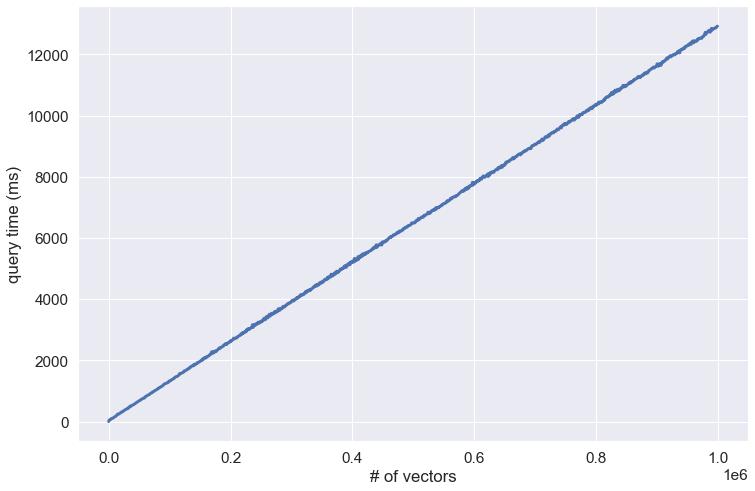

In [8]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='num_vectors', y='query_time', data=tests[tests['test'] == 'FlatL2'], linewidth=3)
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')

---

# IndexIVFFlat

In [9]:
nlist = 50
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)

In [10]:
for nprobe in [1, 5, 10, 20]:
    index.nprobe = nprobe
    dim, time = test(index)
    df = pd.DataFrame({
        'num_vectors': dim.tolist(),
        'query_time': time.tolist()
    })
    df['test'] = f'IVFFlat_{nprobe}'
    tests = tests.append(df, ignore_index=True)

100%|██████████| 20/20 [01:46<00:00,  5.34s/it]


Text(0, 0.5, 'query time (ms)')

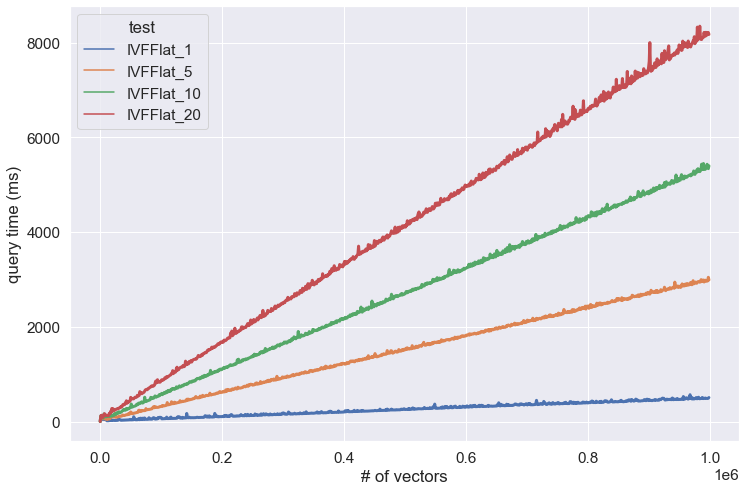

In [11]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='num_vectors', y='query_time', data=tests[tests['test'].str.contains('IVFFlat')], linewidth=3, hue='test')
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')

# IndexIVFPQ

In [12]:
m = 5  # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(d)  # we keep the same L2 distance flat index
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits)

In [13]:
dim, time = test(index)
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'IVFPQ'
tests = tests.append(df, ignore_index=True)

100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


Text(0, 0.5, 'query time (ms)')

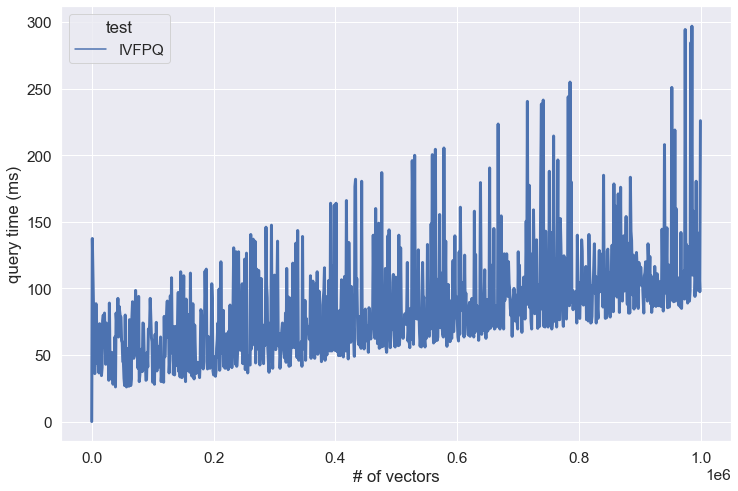

In [14]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='num_vectors', y='query_time', data=tests[tests['test'] == 'IVFPQ'], linewidth=3, hue='test')
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')

# Plot All

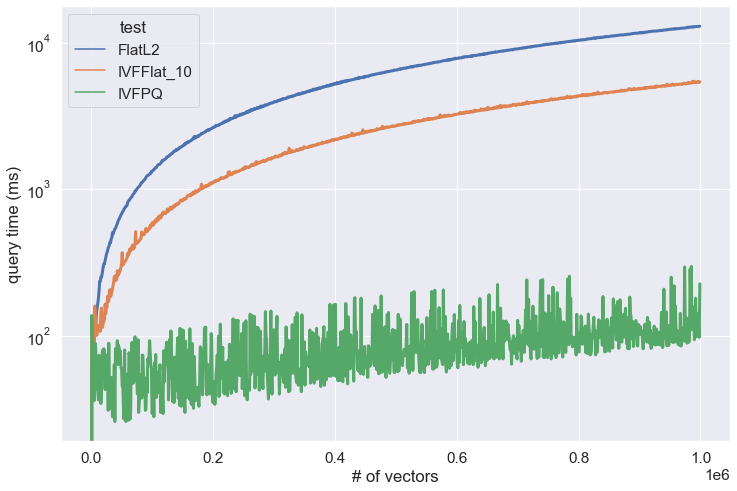

In [15]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='num_vectors', y='query_time', data=tests[~tests['test'].isin(['IVFFlat_1', 'IVFFlat_5', 'IVFFlat_20'])], linewidth=3, hue='test')
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')
plt.yscale('log')
